# Calibration Exercice

This exercise is about calibration, that is to make a certain type of method or measurement more precise by taking into account effects that otherwise blurs the precision of the method by correcting for these effects. The below example is constructed/invented, but outlines the considerations.

## Description
  You're developping a new method for measuring the distance to stars, and want to
  calibrate and thus improve this method, such that the precision obtained is unbiased
  and has a minimal variance. You know that the method depends on several factors, such as:
   * Amount of signal light from the star `lsig`
   * Amount of background light in the surrounding sky `lbkg`
   * Temperature of star `temp`
   * Transparency of sky `tsky`

In order to determine the influence of these factors, and how much you need to correct for each of them, you consider 10.000 stars with known distances (measured by another method, e.g. triangulation). From these, you can find how well your own method works, make corrections to biases as needed, and finally find out how precise your calibrated method is. Happy calibration.


## Your Task

* As always look at the data and get a feel for each of the variables. A good idea might be to plot them all to know what range to expect them in.

* First, consider the raw distribution of "relative differences" ($R_D$) between the observed and actual distance: $R_{D} = \frac{(D_{obs} - D_{known})}{D_{known}}$. You'll notice that this distribution is far from an ideal (and narrow) gaussian, which is why you'll need to calibrate the underlying data. Your calibration technique should be able to do the following:

    - Reduce the RMS of the distribution
    - Correct the offset from zero
    - Mitigate the tail at high values

* Secondly, look at the distribution of the bias and relative precision as a function of the data variables. Try to identify variables that are correlated with the relative differences, and apply a correction factor to eliminate these biases.


Note that if you are on average say 50% too high compared to the true values, then you need to correct by 50%, i.e. divide by (1 + 0.5), and in general, if your measurement is $f(x)$ off, where $f(x)$ describes the offset, then you need to divide by $(1 + f(T))$:

$R_{D} = \frac{d - d_{true}}{d_{true}}  \rightarrow  d_{calib} = \frac{d}{(1 + f(x))}$


Thus, define `d_calib = d / (1 + f(x))`, and continue using `d_calib` when considering other effects.


##  Author: 
- Troels Petersen ([email](mailto:petersen@nbi.dk))

##  Date:   
10th of December 2020

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from iminuit import Minuit
from scipy import stats
import os, sys                                         # Modules to see files and folders in directories
from os.path import dirname as parent_folder

In [2]:
sys.path.append('../../../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

In [3]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

In [4]:
verbose = True
Nverbose = 10
SaveFigures = False

### Define functions:

In [5]:
# Profile x of the two arrays x and y with defined number of bins and range
# returns the x-values of the profile, the means and the standard deviations.
def profile_x(x, y, bins=(50, 50), xyrange=[(0, 50), (-1,1)]):
    
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=xyrange)
    x_center = 0.5*(xedges[1:] + xedges[:-1])
    y_center = 0.5*(yedges[1:] + yedges[:-1])
    
    wsums = H.sum(1)
    
    mask = wsums > 0
    
    mean = (H*y_center).sum(1)[mask] / wsums[mask]
    mean_squared = (H*y_center**2).sum(1)[mask] / wsums[mask]
    std = np.sqrt( mean_squared - mean**2 ) / np.sqrt(wsums[mask]) 

    return x_center[mask], mean, std


def parabola(x, p0, p1, p2):
    return p0 + p1*x + p2*x**2


def exponential(x, p0, p1, p2):
    return p0 + p1*np.exp(p2*x)


def gauss_pdf(x, mu, sigma):
    """Normalized Gaussian"""
    return 1 / np.sqrt(2 * np.pi) / sigma * np.exp(-(x - mu) ** 2 / 2. / sigma ** 2)


def gauss_extended(x, N, mu, sigma):
    """Non-normalized Gaussian"""
    return N * binwidth * gauss_pdf(x, mu, sigma)

### Reading the data (text) file:

There are multiple ways we can retrieve the information from a text file, but here we use the `loadtxt` function of the `numpy` package. This is a very powerful function that allows you to parse an entire textfile in a single line, _provided that the text file is formatted properly_. For more advanced parsing option, you can also check out `numpy.genfromtxt`.

In [6]:
filename = "data_calib.txt"
dknown, dmeas, lsig, lbkg, temp, tsky = np.loadtxt(filename, unpack=True)

In [7]:
# Check that this worked:
if (verbose) :
    for i in range(Nverbose) :
        print("  Distance (known) = {:8.2f}    Distance (measured) = {:6.3f} ".format(dknown[i], dmeas[i]))
print("The TOTAL number of entries read is: ", len(dmeas))

  Distance (known) =  9209.51    Distance (measured) = 5820.208 
  Distance (known) =   149.38    Distance (measured) = 174.093 
  Distance (known) =   412.18    Distance (measured) = 423.608 
  Distance (known) =   119.81    Distance (measured) = 126.137 
  Distance (known) =   175.10    Distance (measured) = 250.720 
  Distance (known) =   146.20    Distance (measured) = 227.391 
  Distance (known) =   324.05    Distance (measured) = 422.474 
  Distance (known) =   256.97    Distance (measured) = 229.279 
  Distance (known) =   175.40    Distance (measured) = 156.558 
  Distance (known) =   353.27    Distance (measured) = 353.121 
The TOTAL number of entries read is:  10000


### Make Histograms and vectors:

In [8]:
plt.ioff() # We use to hide the empty plot on this cell
fig_rel, ax_rel = plt.subplots(figsize=(15, 8));
ax_rel.set_title('Hist relative resolution');
Nbins = 200
xmin, xmax = -2.0, 2.0
binwidth = (xmax-xmin) / Nbins

In [9]:
fig_lsig2D, ax_lsig2D = plt.subplots(figsize=(12,8));
ax_lsig2D.set_title('Hist lsig 2D')

Text(0.5, 1.0, 'Hist lsig 2D')

### Loop over data and make plots: (TO DO YOURSELF)
--------

## Look at the raw data first

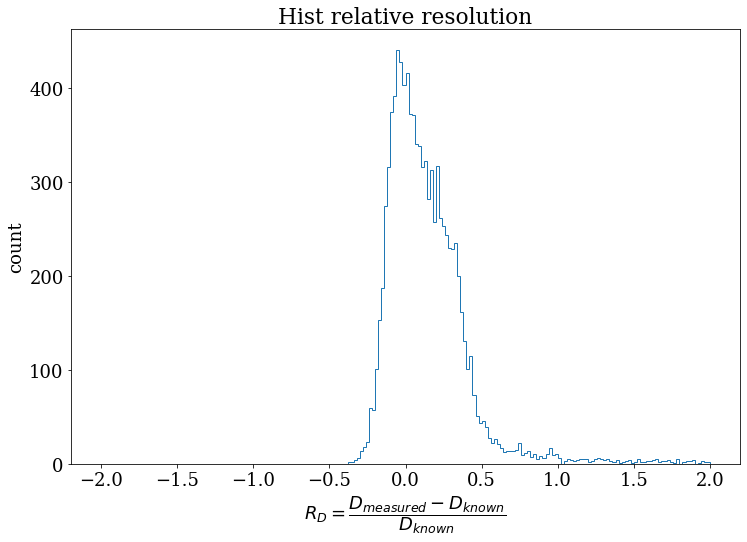

In [10]:
plt.ioff() # We use to hide the empty plot on this cell
fig_rel, ax_rel = plt.subplots(figsize=(12, 8));
ax_rel.set_title('Hist relative resolution');
Nbins = 200
xmin, xmax = -2,2
binwidth = (xmax-xmin) / Nbins


distrel = (dmeas - dknown) / dknown
ax_rel.hist(distrel, bins=Nbins, range=(xmin, xmax), histtype='step', label='Raw');
ax_rel.set_xlabel(r'$R_{D} = \dfrac{D_{measured}-D_{known}}{D_{known}}$')
ax_rel.set_ylabel('count')
fig_rel

#### __We can effectively see that the raw data is pretty bad, with a clearly non-gaussian shape, and a large tail toward positive values.Now let's plot $R_{D}$ as a function of all four variables:__

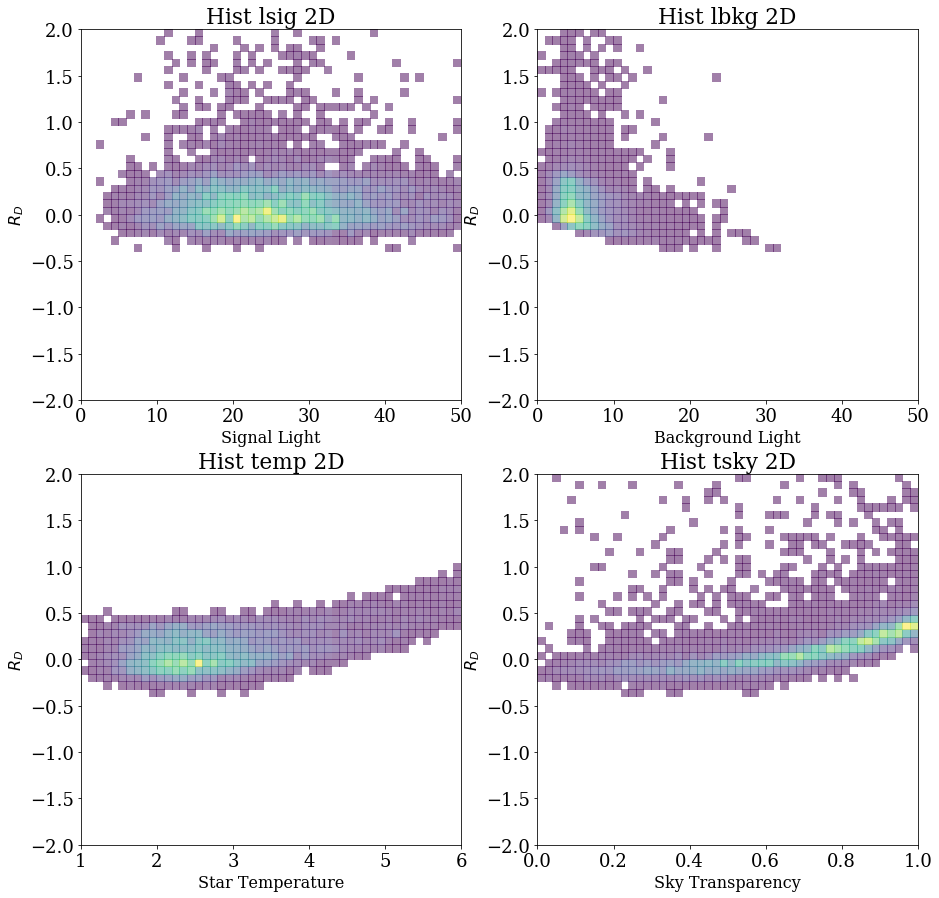

In [11]:
fig_2D, axes = plt.subplots(2,2,figsize=(15,15));

ax_lsig2D = axes[0,0]
ax_lbkg2D = axes[0,1]
ax_temp2D = axes[1,0]
ax_tsky2D = axes[1,1]

ax_lsig2D.set_title('Hist lsig 2D');
ax_lbkg2D.set_title('Hist lbkg 2D');
ax_temp2D.set_title('Hist temp 2D');
ax_tsky2D.set_title('Hist tsky 2D');

## Define a binning for all four variables
binning_RD   = (-2.,2.)
binning_lsig = (0, 50)
binning_lbkg = (0, 50)
binning_temp = (1, 6)
binning_tsky = (0, 1)

ax_lsig2D.hist2d(lsig, distrel, bins=50, range=[binning_lsig, binning_RD], cmin=1, alpha=0.5);
ax_lbkg2D.hist2d(lbkg, distrel, bins=50, range=[binning_lbkg, binning_RD], cmin=1, alpha=0.5);
ax_temp2D.hist2d(temp, distrel, bins=50, range=[binning_temp, binning_RD], cmin=1, alpha=0.5);
ax_tsky2D.hist2d(tsky, distrel, bins=50, range=[binning_tsky, binning_RD], cmin=1, alpha=0.5);

ax_lsig2D.set_ylabel(r'$R_{D}$',fontsize=16)
ax_lbkg2D.set_ylabel(r'$R_{D}$',fontsize=16)
ax_temp2D.set_ylabel(r'$R_{D}$',fontsize=16)
ax_tsky2D.set_ylabel(r'$R_{D}$',fontsize=16)

ax_lsig2D.set_xlabel(r'Signal Light',fontsize=16)
ax_lbkg2D.set_xlabel(r'Background Light',fontsize=16)
ax_temp2D.set_xlabel(r'Star Temperature',fontsize=16)
ax_tsky2D.set_xlabel(r'Sky Transparency',fontsize=16)

fig_2D

__As it was underlined in the exercice, there seems to be no large correlation between $R_{D}$ and the signal light from the data. There are however significant correlations between $R_{D}$ and the Sky Transparency, as well as with the Background light.__

---
### Fitting each variable with a functional trend

__We use a polynomial of degree 2 to model the trend in both `temp` and `lbkg`. For `tsky` we use a constant plus an exponential function.__


#### _Star Temperature `temp`_

First find the mean and standard deviation of each "slice" of $R_{D}$ distribution, for each central value of the `temp` bins:

In [12]:
x_center_temp2D, mean_temp2D, std_temp2D = profile_x(temp, distrel, bins=(50, 50), xyrange=[binning_temp, binning_RD])
x_binwidth_temp2D = x_center_temp2D[1] - x_center_temp2D[0]

ax_temp2D.errorbar(x_center_temp2D, mean_temp2D, xerr=x_binwidth_temp2D/2, yerr=std_temp2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1);


#### Perform the fit on the means and standard deviations found above:

In [13]:
# Note the use of the mask to fit only the data contained within the histogram range
mask = (1 < x_center_temp2D) & (x_center_temp2D < 6)

chi2_object = Chi2Regression(parabola, x_center_temp2D[mask], mean_temp2D[mask], std_temp2D[mask]) 

minuit = Minuit(chi2_object, pedantic=False, p0=1, p1=1, p2=1)  
minuit.migrad();  # perform the actual fit

print("temp:")
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
x_fit = np.linspace(0, 25, 1000) # Create the x-axis for the plot of the fitted function
y_fit = parabola(x_fit, *minuit.args) # the fitted function

ax_temp2D.plot(x_fit, y_fit, '-', color='green', lw=2,label='fit');


Chi2 = minuit.fval
ndof = len(x_center_temp2D[mask])-3
d = {'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2,ndof) ,
     'Prob'      : "{:.3f}".format(stats.chi2.sf(Chi2, ndof)),
     'p0'        : "{:.3f} +/- {:.3f}".format(minuit.values['p0'], minuit.errors['p0']),
     'p1'        : "{:.3f} +/- {:.3f}".format(minuit.values['p1'], minuit.errors['p1']),
     'p2'        : "{:.3f} +/- {:.3f}".format(minuit.values['p2'], minuit.errors['p2'])}

ax_temp2D.text(0.6, 0.2, nice_string_output(d, 0), family='monospace', 
               transform=ax_temp2D.transAxes, fontsize=9, color='k', verticalalignment='top');


temp_par = [minuit.values['p0'],minuit.values['p1'],minuit.values['p2']]

temp:
Fit value: p0 = 0.21201 +/- 0.01510
Fit value: p1 = -0.15806 +/- 0.00967
Fit value: p2 = 0.03877 +/- 0.00144


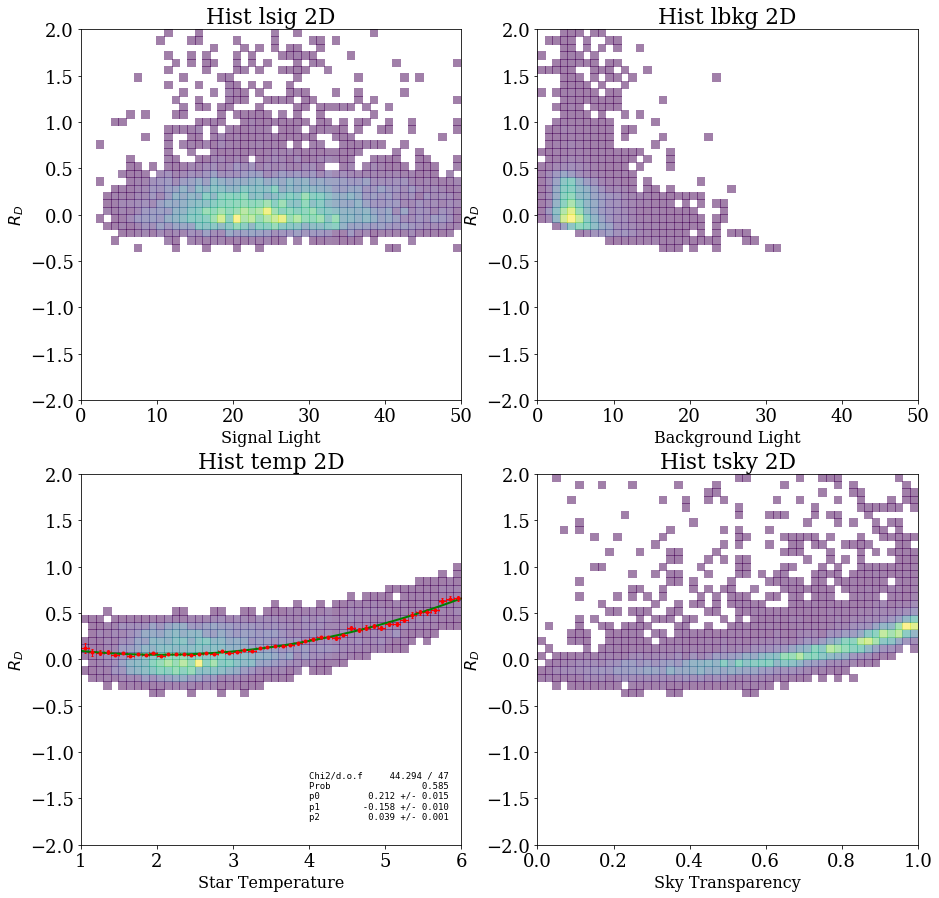

In [14]:
fig_2D

### __alright, it's not the best of fits but let's say it's good enough for now... Moving on to the Background light:__

Note that for distribution, a first look at the histogram by eye would make you think that an asymptotic function would be more appropriate than a polynomial (something like $Aln(x+b)$). However, if you plot the means and standard deviations of each distribution slice, you'll see a different trend emerge (this one, more compatible with the parabola).

In [15]:
x_center_lbkg2D, mean_lbkg2D, std_lbkg2D = profile_x(lbkg, distrel, bins=(50, 50), xyrange=[binning_lbkg, binning_RD])
x_binwidth_lbkg2D = x_center_lbkg2D[1] - x_center_lbkg2D[0]

ax_lbkg2D.errorbar(x_center_lbkg2D, mean_lbkg2D, xerr=x_binwidth_lbkg2D/2, yerr=std_lbkg2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1);

In [16]:
mask = (0 < x_center_lbkg2D) & (x_center_lbkg2D < 25) & ( std_lbkg2D > 0 )


chi2_object_bkg = Chi2Regression(parabola, x_center_lbkg2D[mask], mean_lbkg2D[mask], std_lbkg2D[mask]) 

minuit = Minuit(chi2_object_bkg, pedantic=False, p0=1, p1=1, p2=1)  
minuit.migrad()


print("lbkg:")

for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    
x_fit = np.linspace(0, 25, 1000) # Create the x-axis for the plot of the fitted function
y_fit = parabola(x_fit, *minuit.args) # the fitted function

ax_lbkg2D.plot(x_fit, y_fit, '-', color='green', lw=2,label='fit');


Chi2 = minuit.fval
ndof = len(x_center_lbkg2D[mask])-3
d = {'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2,ndof) ,
     'Prob'      : "{:.3f}".format(stats.chi2.sf(Chi2, ndof)),
     'p0'        : "{:.3f} +/- {:.3f}".format(minuit.values['p0'], minuit.errors['p0']),
     'p1'        : "{:.3f} +/- {:.3f}".format(minuit.values['p1'], minuit.errors['p1']),
     'p2'        : "{:.3f} +/- {:.3f}".format(minuit.values['p2'], minuit.errors['p2'])}

ax_lbkg2D.text(0.6, 0.6, nice_string_output(d, 0), family='monospace', 
               transform=ax_lbkg2D.transAxes, fontsize=9, color='k', verticalalignment='top');

lbkg_par = [minuit.values['p0'],minuit.values['p1'],minuit.values['p2']]

lbkg:
Fit value: p0 = 0.27642 +/- 0.00901
Fit value: p1 = -0.02796 +/- 0.00225
Fit value: p2 = 0.00061 +/- 0.00011


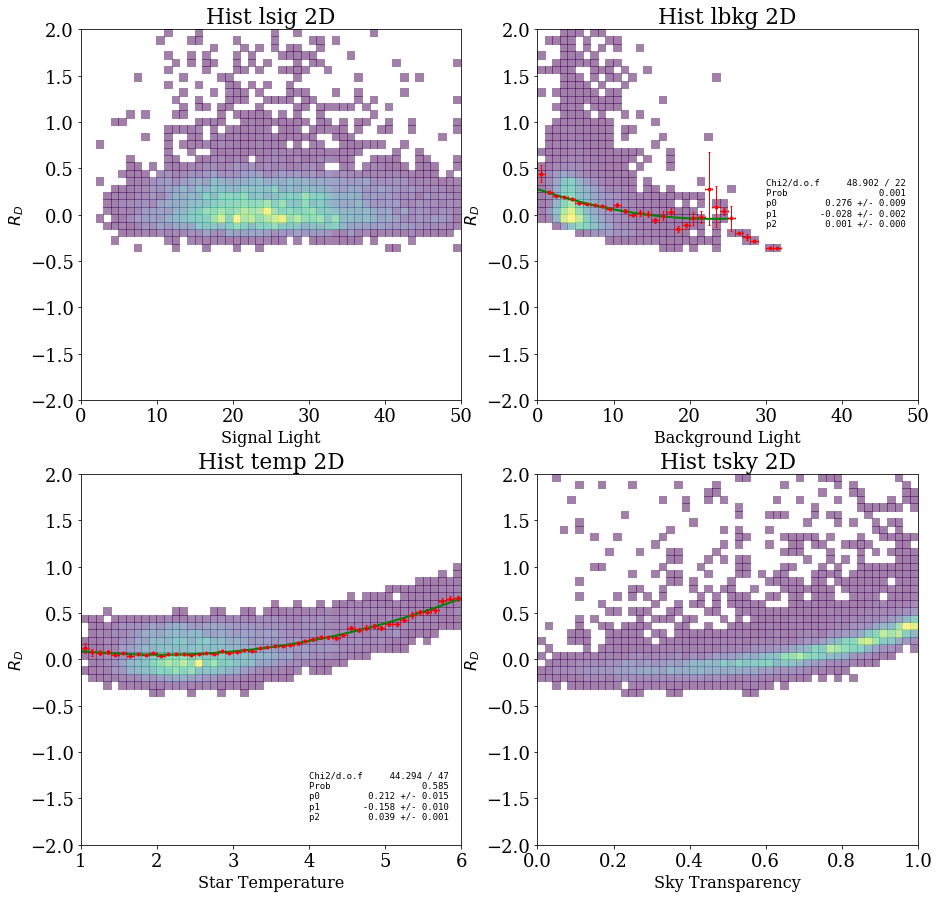

In [17]:
fig_2D

### __Moving on to the Sky Transparency:__

In [18]:
x_center_tsky2D, mean_tsky2D, std_tsky2D = profile_x(tsky, distrel, bins=(50, 50), xyrange=[binning_tsky, binning_RD])
x_binwidth_tsky2D = x_center_tsky2D[1] - x_center_tsky2D[0]

ax_tsky2D.errorbar(x_center_tsky2D, mean_tsky2D, xerr=x_binwidth_tsky2D/2, yerr=std_tsky2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1);


In [19]:
mask = (0 < x_center_tsky2D) & (x_center_tsky2D < 1)


chi2_object = Chi2Regression(exponential, x_center_tsky2D[mask], mean_tsky2D[mask], std_tsky2D[mask]) 

minuit = Minuit(chi2_object, pedantic=False, p0=-0.2, p1=0.02, p2=1.0)  
minuit.migrad()


print("tsky:")
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
x_fit = np.linspace(0, 1, 1000) # Create the x-axis for the plot of the fitted function
y_fit = exponential(x_fit, *minuit.args) # the fitted function
ax_tsky2D.plot(x_fit, y_fit, '-', color='green', lw=2,label='fit'); 


Chi2 = minuit.fval
ndof = len(x_center_tsky2D[mask])-3
d = {'Chi2/d.o.f': "{:.3f} / {:d}".format(Chi2,ndof) ,
     'Prob'      : "{:.3f}".format(stats.chi2.sf(Chi2, ndof)),
     'p0'        : "{:.3f} +/- {:.3f}".format(minuit.values['p0'], minuit.errors['p0']),
     'p1'        : "{:.3f} +/- {:.3f}".format(minuit.values['p1'], minuit.errors['p1']),
     'p2'        : "{:.3f} +/- {:.3f}".format(minuit.values['p2'], minuit.errors['p2'])}

ax_tsky2D.text(0.6, 0.2, nice_string_output(d, 0), family='monospace', 
               transform=ax_tsky2D.transAxes, fontsize=9, color='k', verticalalignment='top');

tsky_par = [minuit.values['p0'],minuit.values['p1'],minuit.values['p2']]

tsky:
Fit value: p0 = -0.09679 +/- 0.00913
Fit value: p1 = 0.01697 +/- 0.00278
Fit value: p2 = 3.48114 +/- 0.15610


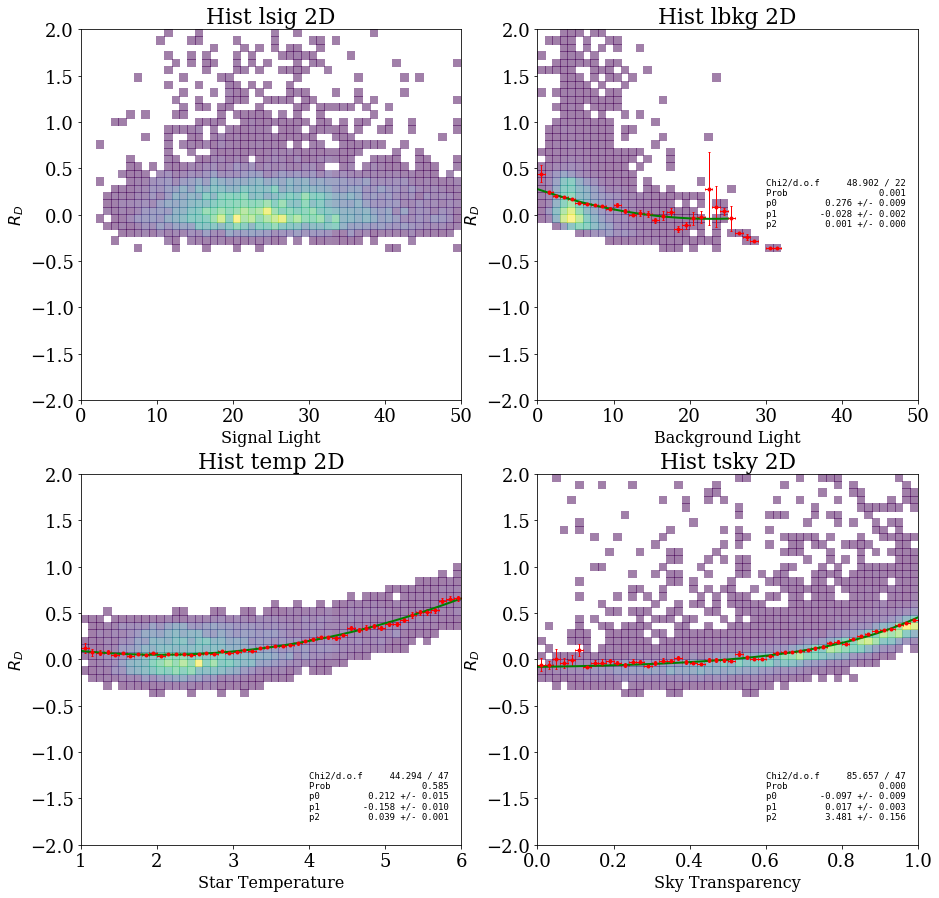

In [20]:
fig_2D

----

In [21]:
# The initial relative resolution:
distrel = (dmeas - dknown) / dknown

In [22]:
# Apply calibration as found from the 2D plot below:
# dmeas_calib = dmeas / (1 + dmed)      # So here is so far no calibration - that is what you have to change!!!

calib_temp = temp_par[0] + temp_par[1]*temp + temp_par[2]*temp**2
calib_lbkg = lbkg_par[0] + lbkg_par[1]*lbkg + lbkg_par[2]*lbkg**2
calib_tsky = tsky_par[0] + tsky_par[1]*np.exp(tsky_par[2]*tsky)

dmeas_calib = dmeas / (1.0 + calib_temp) / (1.0 + calib_lbkg) / (1.0 + calib_tsky)

In [23]:
# Once you have made the calibration, the (improved) relative resolution becomes:
distrel_calib = (dmeas_calib - dknown) / dknown

In [24]:
# Determine the resolution (quantified as the RMS) before and after the calibration:
mask_distrel       = (xmin < distrel) & (distrel < xmax)
mask_distrel_calib = (xmin < distrel_calib) & (distrel_calib < xmax)
print("  The initial and final resolutions are:  {:6.3f}  and  {:6.3f} \n".format(
        distrel[mask_distrel].std(ddof=1), distrel_calib[mask_distrel_calib].std(ddof=1)))

  The initial and final resolutions are:   0.269  and   0.025 



## Compare the raw and calibrated data on a plot

In [25]:
ax_rel.hist(distrel, bins=Nbins, range=(xmin, xmax), histtype='step', label='Raw')
hist_rel_calib = ax_rel.hist(distrel_calib, bins=Nbins, range=(xmin, xmax), histtype='step', label='Calibration')

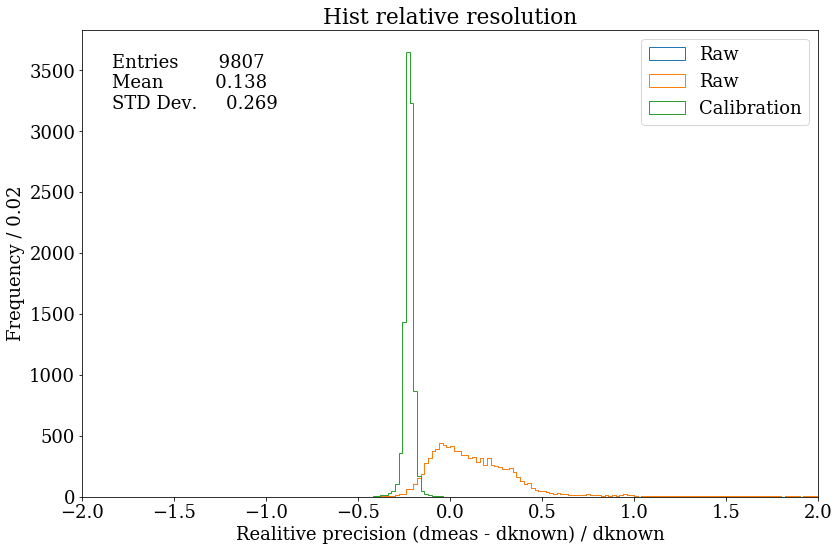

In [26]:
# Plotting attributes
ax_rel.set_xlim(xmin, xmax)
ax_rel.set_xlabel('Realitive precision (dmeas - dknown) / dknown',fontsize=18)
ax_rel.set_ylabel('Frequency / 0.02', fontsize=18)
ax_rel.legend(loc='best', fontsize=18)

d = {'Entries':"{:d}".format(len(distrel[mask_distrel])), 
     'Mean':"{:.3f}".format(distrel[mask_distrel].mean()), 
     'STD Dev.':"{:.3f}".format(distrel[mask_distrel].std(ddof=1))}

ax_rel.text(0.04, 0.95, nice_string_output(d), family='serif', fontsize=18, 
        transform=ax_rel.transAxes, verticalalignment='top')
fig_rel.tight_layout()
plt.ion()
fig_rel

In [27]:
if (SaveFigures):
    fig_rel.savefig('UncalibratedCalibrated.pdf', dpi=600)

### Let's go a bit further...

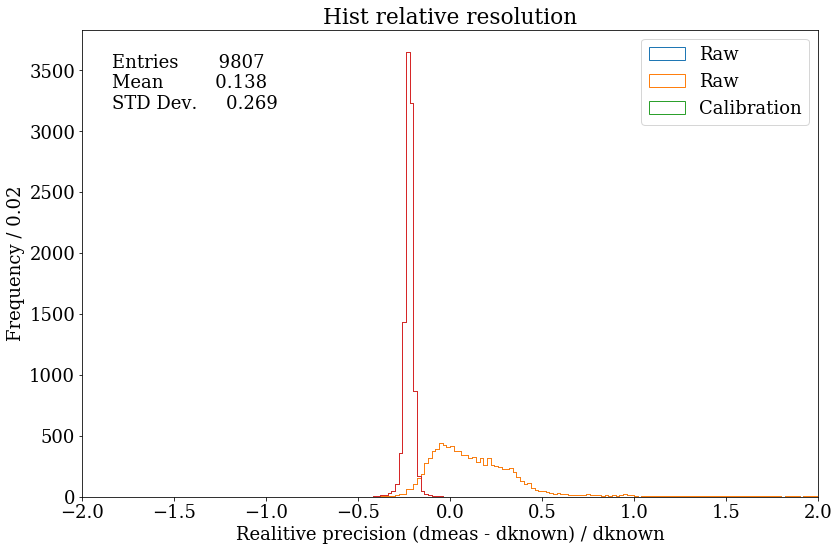

In [28]:
distrel_calib = (dmeas_calib - dknown) / dknown
distrel_interval_mean = distrel[(xmin <= distrel) & (distrel <= xmax)].mean()
distrel_interval_std = distrel[(xmin <= distrel) & (distrel <= xmax)].std(ddof=1)

distrel_calib_interval_mean = distrel_calib[(xmin <= distrel_calib) & (distrel_calib <= xmax)].mean()
distrel_calib_interval_std = distrel_calib[(xmin <= distrel_calib) & (distrel_calib <= xmax)].std(ddof=1)

hist_rel_calib = ax_rel.hist(distrel_calib, bins=Nbins, range=binning_RD, histtype='step', label='Calibration')

fig_rel

In [29]:
entries, bin_edges, _ = hist_rel_calib
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
hist_x, hist_y = bin_centers, entries
hist_sy = np.sqrt(hist_y)

chi2_object = Chi2Regression(gauss_extended, hist_x[hist_y>0], hist_y[hist_y>0], hist_sy[hist_y>0])

minuit = Minuit(chi2_object, pedantic=False, mu=distrel_calib_interval_mean, sigma=distrel_calib_interval_std, N=10000)  
minuit.migrad()

fit_N, fit_mu, fit_sigma = minuit.args # the fitted values of the parameters
for name in minuit.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))

    
x_fit = np.linspace(-1, 1, 1000) # Create the x-axis for the plot of the fitted function
y_fit = gauss_extended(x_fit, fit_N, fit_mu, fit_sigma) # the fitted function

ax_rel.plot(x_fit, y_fit, '-', color='blue', label='Fit with Gaussian to calibrated data')



Fit value: N = 9670.48131 +/- 98.33790
Fit value: mu = -0.22336 +/- 0.00021
Fit value: sigma = 0.02064 +/- 0.00019


In [30]:
# Chi2 value of the fit, and the number on non-zero bins!
chi2_val = 0
N_NotEmptyBin = 0
for x, y, sy in zip(hist_x, hist_y, hist_sy):
    if y > 0:
        f = gauss_extended(x, fit_N, fit_mu, fit_sigma) # calc the model value
        residual  = ( y-f ) / sy  # find the uncertainty-weighted residual
        chi2_val += residual**2  # the chi2-value is the squared residual
        N_NotEmptyBin += 1 # count the bin as non-empty since sy>0 (and thus y>0)
N_DOF = N_NotEmptyBin - len(minuit.args)

from scipy import stats
chi2_prob =  stats.chi2.sf(chi2_val, N_DOF) # The chi2 probability given N_DOF degrees of freedom

In [31]:
d = {'Entries' : "{:d}".format(len(distrel_calib)), 
     'Mean'    : "{:.6f}".format(distrel_calib_interval_mean), 
     'STD Dev' : "{:.5f}".format(distrel_calib_interval_std), 
     'Chi2/ndf': "{:.3f} / {:.3f}".format(chi2_val, N_DOF), 
     'Prob'    : "{:.3f}".format(chi2_prob),
     'Constant': "{:.3f} +/- {:.3f}".format(minuit.values['N'], minuit.errors['N']),
     'Mu'      : "{:.6f} +/- {:.6f}".format(minuit.values['mu'], minuit.errors['mu']),
     'Sigma'   :"{:.5f} +/- {:.5f}".format(minuit.values['sigma'], minuit.errors['sigma'])}


ax_rel.text(0.6, 0.45, nice_string_output(d), family='monospace', 
        transform=ax_rel.transAxes, fontsize=12, verticalalignment='top');


ax_rel.set_xlim(-0.55,0.55)
ax_rel.set_xlabel('Relative precision (dmeas - dknown) / dknown')
ax_rel.set_ylabel('Frequency')
ax_rel.legend(loc='best')

fig_rel
print("  The initial and final resolutions are:  {:6.3f}  and  {:6.3f} \n".format(
        distrel_interval_std, distrel_calib_interval_std))

  The initial and final resolutions are:   0.269  and   0.025 



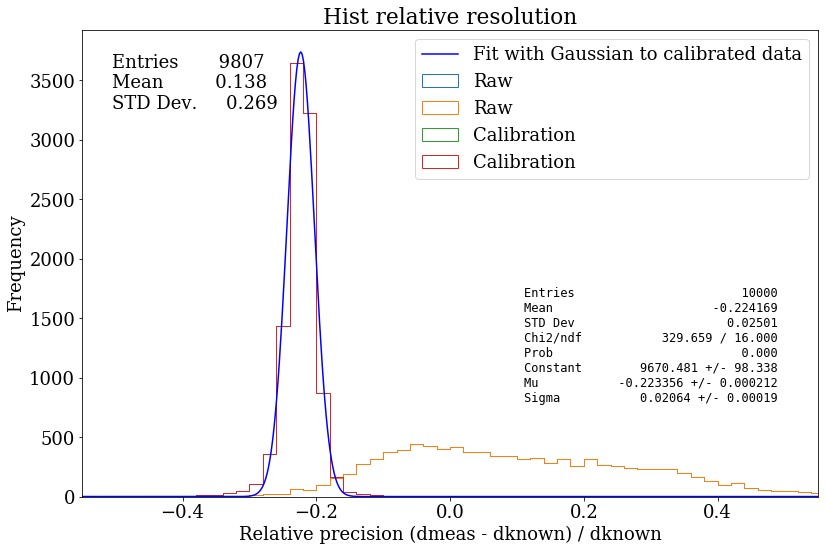

In [32]:
fig_rel

### Finally, check the calibration on the individual variables

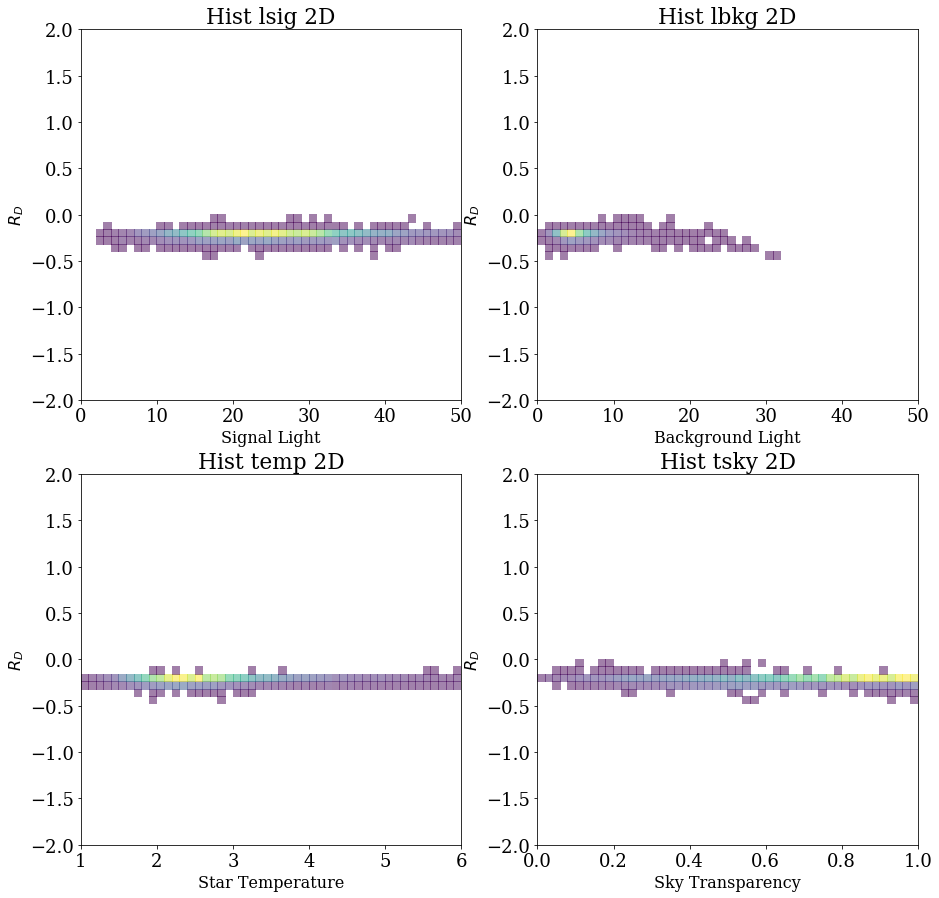

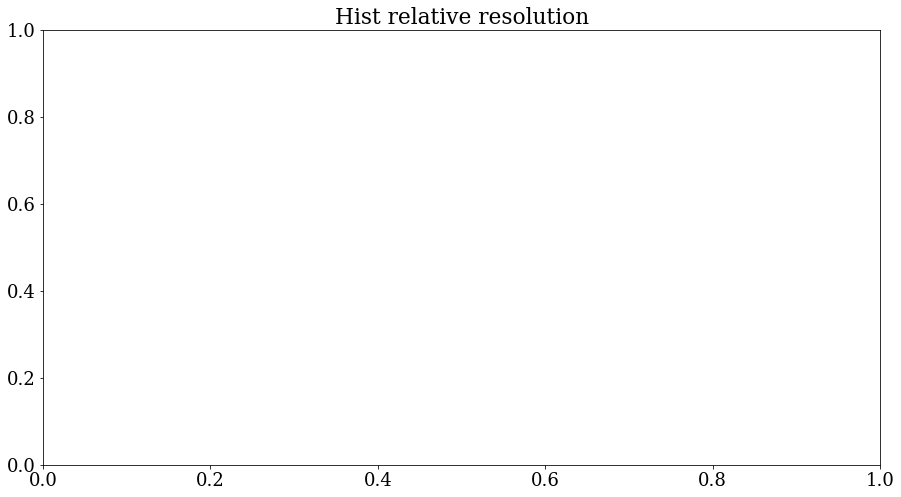

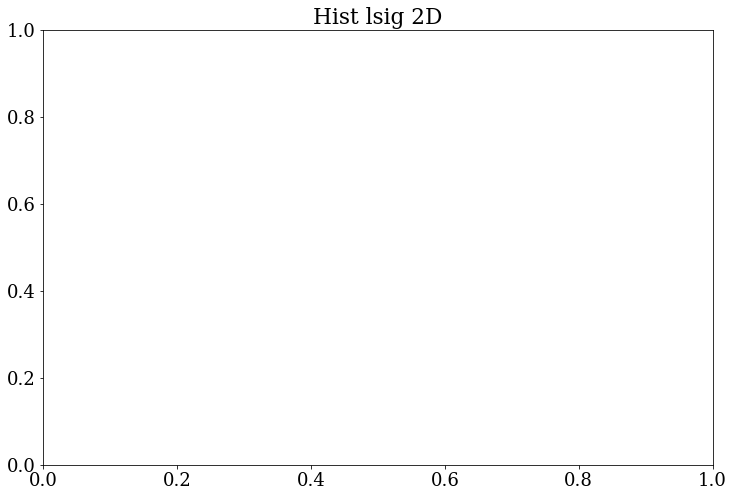

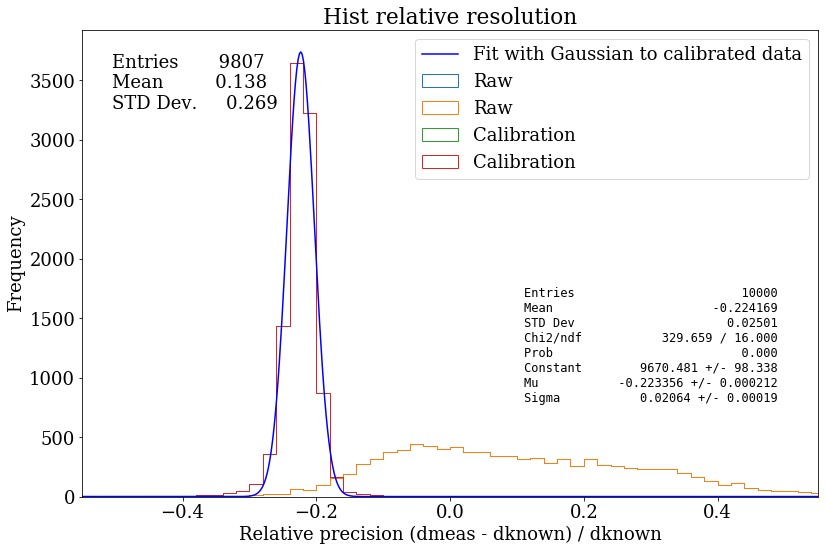

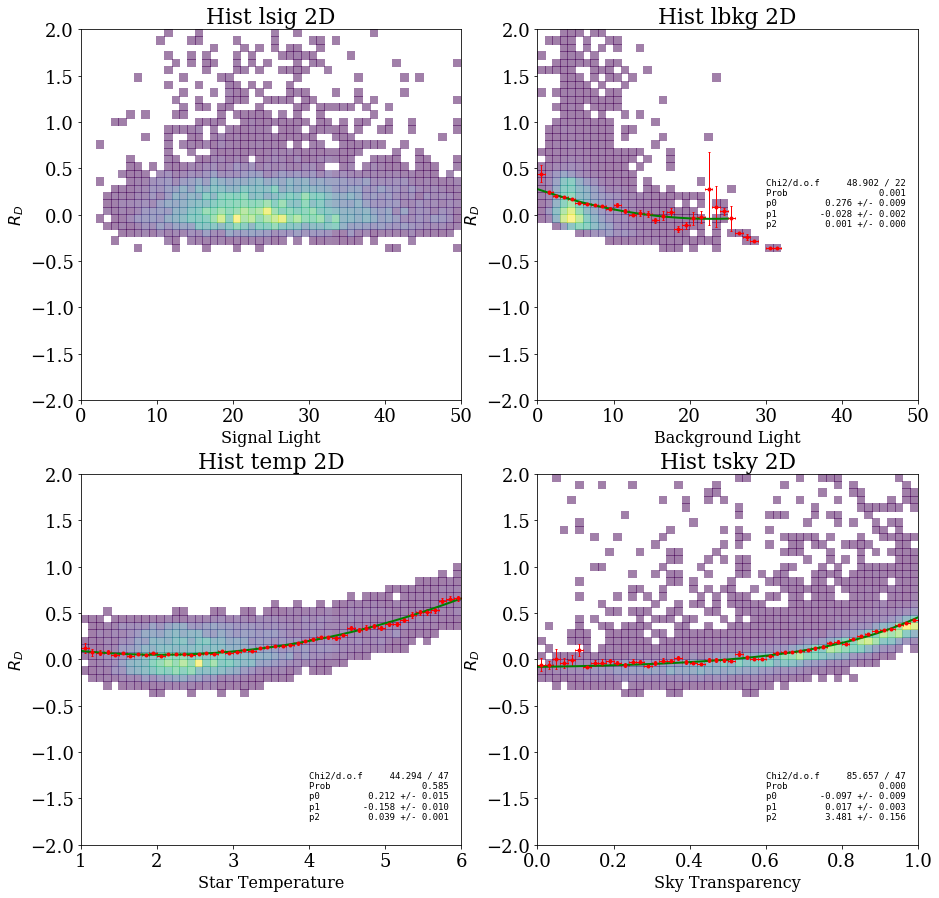

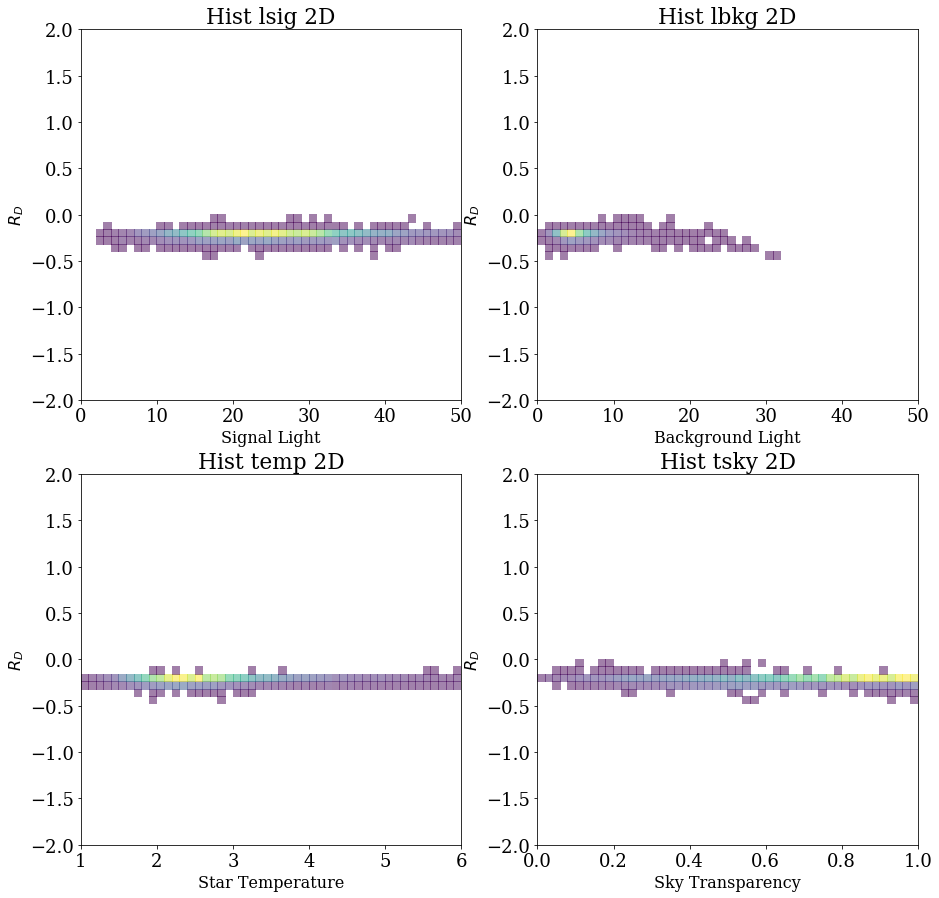

In [33]:
fig_2D_calib, axes_calib = plt.subplots(2,2,figsize=(15,15));

ax_lsig2Dc = axes_calib[0,0]
ax_lbkg2Dc = axes_calib[0,1]
ax_temp2Dc = axes_calib[1,0]
ax_tsky2Dc = axes_calib[1,1]

ax_lsig2Dc.set_title('Hist lsig 2D');
ax_lbkg2Dc.set_title('Hist lbkg 2D');
ax_temp2Dc.set_title('Hist temp 2D');
ax_tsky2Dc.set_title('Hist tsky 2D');

ax_lsig2Dc.hist2d(lsig, distrel_calib, bins=50, range=[binning_lsig, binning_RD], cmin=1, alpha=0.5);
ax_lbkg2Dc.hist2d(lbkg, distrel_calib, bins=50, range=[binning_lbkg, binning_RD], cmin=1, alpha=0.5);
ax_temp2Dc.hist2d(temp, distrel_calib, bins=50, range=[binning_temp, binning_RD], cmin=1, alpha=0.5);
ax_tsky2Dc.hist2d(tsky, distrel_calib, bins=50, range=[binning_tsky, binning_RD], cmin=1, alpha=0.5);

ax_lsig2Dc.set_ylabel(r'$R_{D}$',fontsize=16)
ax_lbkg2Dc.set_ylabel(r'$R_{D}$',fontsize=16)
ax_temp2Dc.set_ylabel(r'$R_{D}$',fontsize=16)
ax_tsky2Dc.set_ylabel(r'$R_{D}$',fontsize=16)

ax_lsig2Dc.set_xlabel(r'Signal Light',fontsize=16)
ax_lbkg2Dc.set_xlabel(r'Background Light',fontsize=16)
ax_temp2Dc.set_xlabel(r'Star Temperature',fontsize=16)
ax_tsky2Dc.set_xlabel(r'Sky Transparency',fontsize=16)

fig_2D_calib


##  Calibration using 2D histograms:

The way to investigate, if there is a (cor)relation between the target (relative distance) and any of the factors/variables/auxiliary observables, is to plot them against each other. If there are any visible relation, then this is an effect of the ourside factors (lsig, lbkg, temp, and tsky) on the wanted observable (relative distance), which we want to correct for.

In the following, we produce this 2D histogram along with a 1D graph on top showing the mean and uncertainty for each bin in x. This graph shows any possible (average) relation in a way, which can be easily fitted.

In [34]:
# Histograms for making calibration:
ax_lsig2D.hist2d(lsig, distrel, bins=50, range=[(0, 50), (-1,1)], cmin=1, alpha=0.5)
ax_lsig2D.set_xlabel('Signal light from star (lsig)');
ax_lsig2D.set_ylabel('Realitive precision (dmeas - dknown) / dknown');

In [35]:
# This calculates the 1D "profile" of the 2D histogram:
x_center_lsig2D, mean_lsig2D, std_lsig2D = profile_x(lsig, distrel, bins=(50, 50), xyrange=[(0, 50), (-1,1)])
x_binwidth_lsig2D = x_center_lsig2D[1] - x_center_lsig2D[0]

In [36]:
ax_lsig2D.errorbar(x_center_lsig2D, mean_lsig2D, xerr=x_binwidth_lsig2D/2, yerr=std_lsig2D,  fmt='r.', 
                   ecolor='r', elinewidth=1, capsize=1, capthick=1);

In [37]:
# Fit of the effect from "lsig" in the 1D graph:
def simple_fit(x, p0, p1):
    return p0 + p1*x

In [38]:
chi2_object_simple = Chi2Regression(simple_fit, x_center_lsig2D, mean_lsig2D, std_lsig2D)
minuit_simple = Minuit(chi2_object_simple, pedantic=False, p0=0.0, p1=0.0)
minuit_simple.migrad() # fit
p0, p1 = minuit_simple.args
print("Simple fit result:")
for name in minuit_simple.parameters:
    print("Fit value: {0} = {1:.5f} +/- {2:.5f}".format(name, minuit_simple.values[name], minuit_simple.errors[name]))

Simple fit result:
Fit value: p0 = 0.11513 +/- 0.00604
Fit value: p1 = 0.00001 +/- 0.00022


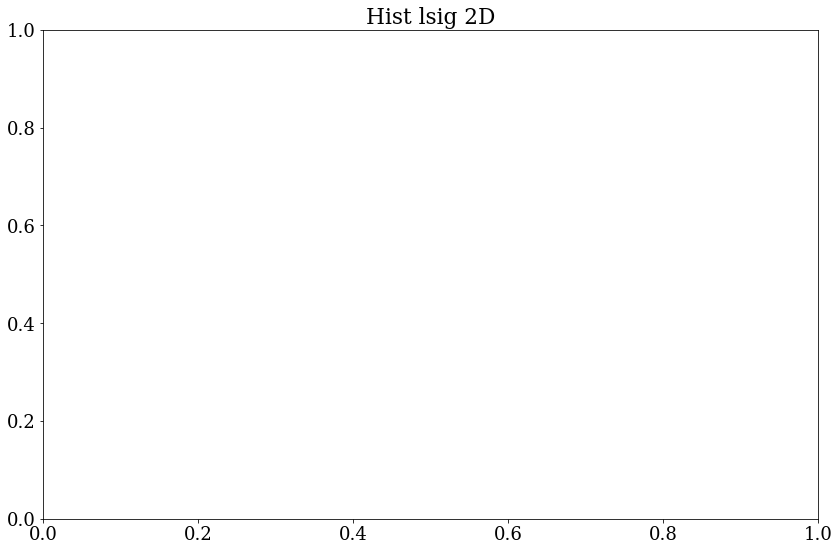

In [39]:
x_fit = np.linspace(0, 50, 1000)
y_fit_simple = simple_fit(x_fit, *minuit_simple.args)
ax_lsig2D.plot(x_fit, y_fit_simple, '--k')

d = {'Entries':"{:d}".format(len(lsig)), 
     'Mean x' :"{:.3f}".format(lbkg.mean()), 
     'Mean y' :"{:.5f}".format(distrel.mean()), 
     'RMS x'  :"{:.3f}".format(lbkg.std(ddof=1)), 
     'RMS y'  :"{:.5f}".format(distrel.std(ddof=1))}

ax_lsig2D.text(0.03, 0.2, nice_string_output(d), family='monospace', 
        transform=ax_lsig2D.transAxes, fontsize=16, verticalalignment='top')
fig_lsig2D.tight_layout()
fig_lsig2D

## Your Task (reminder)

 As always look at the data and get a feel for each of the variables. A good idea might
 be to plot them all to know what range to expect them in.

 Next, consider the distribution of "relative differences" (RD) between the observed
 and actual distance: RD = (dist_obs - dist_known) / dist_known
 
 The Standard Deviation is 0.27, i.e. a 27% precision, and it is neither centered at zero
 (as it should, not to be biased), nor very Gaussian. There is also a long tail towards very
 high values. This is what you want to improve upon!

 Finally, there is the distribution of the bias and relative precision as a function of
 the signal luminosity (lsig). As you can see, the response does not depend on lsig,
 and so there seems to be no (varying) bias from this variable. Check the other three
 variables, and if you find some bias, try to correct for it, such that you get the
 relative difference to be the most narrow Gaussian centered around 0.

 Note that if you are on average say 50% too high compared to the true values, then
 you need to correct by 50%, i.e. divide by (1 + 0.5), and in general, if your
 measurement is f(x) off, where f(x) describes the offset, then you need to divide
 by (1 + f(T)). Why:

   RD = (d - d_true) / d_true  =>  d_true = d / (1 + f(x))

 Thus define d_calib = d / (1 + f(x)), and continue using d_calib when considering
 other effects. In the end, your calibrated measurement can be the result of several
 consecutive corrections (note that the order might matter!).


Questions:
----------
1. What corrections do you apply for each of the variables, and how much do each of them improve on the result?

_Example solution 1:_
The correction functions are in this case a parabola and exponentials with a constant. The last case signifies, that an effect seems to become steady at some point (modelled by the constant). The improvement varies, but expecially the correction with temperature is significant.

---

2. What is the final resolution you obtain?

_Example solution 2:_
The final resolution (i.e. Standard Deviation) is 0.025 or the SD of the Gaussian fit of 0.021, which are both more than a factor 10 improvement over the initial resolution of 0.269 (and non-Gaussian shape). The mean should also be corrected back to zero.

---

3. Do you think that further improvements are possible in this example (constructed by me)? How about in real and more complicated data?

_Example solution 3:_
In this example, one can hardly improve much more. And the example is a "great case" in that one should never expect improvements of a factor 10. But it is sometimes possible to make significant improvements, and given the typical cost of data or the value of the operation behind, simply improving a few percent is worthwhile. Imagine, if you could improve Maersk Line sailing plan by just 1%...

Interestingly, calibration can (given enough historic yet relevant data) be done with Machine Learning.

---

Advanced Questions:
-------------------
4. Try at the end to figure out, which variables the final resolution depends on.
     Can you give an estimate of the uncertainty for each single star?